Parkinson Prediction using Random Forest

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt

In [2]:
#merged_file = pd.read_csv("Data/gene_matrix.csv")
gene_demo_file = pd.read_csv("merged_all.csv")
merged_file = gene_demo_file.dropna()
print("Original shape:", gene_demo_file.shape)
print("Cleaned shape :", merged_file.shape)

null_counts = merged_file.isna().sum()
print(null_counts[null_counts > 0].sort_values(ascending=False))
print(merged_file["GENDER"].unique())
print(merged_file["GENDER"].value_counts(dropna=False))

Original shape: (640, 119)
Cleaned shape : (639, 119)
Series([], dtype: int64)
['Female' 'Male']
GENDER
Male      381
Female    258
Name: count, dtype: int64


In [28]:
nhy_map = {0:0,1:1,2:1,3:1,4:1,5:1}
merged_file.loc[:,"NHY_MAPPED"] = merged_file["NHY"].map(nhy_map)
target_col = "NHY_MAPPED"
merged_file.loc[:,"GENDER_MAPPED"] = merged_file["GENDER"].map({"Male": 0, "Female": 1})


MRI ONLY

In [30]:
cols_to_include = ["lh_MeanThickness","lh_WhiteSurfArea","lhCerebralWhiteMatterVol","Left_Cerebellum_White_Matter","CerebralWhiteMatterVol","lhSurfaceHoles"]
feature_cols_mri = merged_file.columns.intersection(cols_to_include)
X_mri = merged_file[feature_cols_mri]
y = merged_file[target_col]
print("X shape:", X_mri.shape)
print("y shape:", y.shape)

X shape: (639, 6)
y shape: (639,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_mri, y, test_size=0.2, stratify=y, random_state=42
)
pipeline = ImbPipeline([
    ("scale", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)

print(f"CV balanced accuracy (train): {scores.mean():.3f} ± {scores.std():.3f}")

CV balanced accuracy (train): 0.555 ± 0.028


DEMOGRAPHICS + MRI ONLY

In [32]:
cols_to_include = ["GENDER_MAPPED","AGE","EDUC_YRS","lh_MeanThickness","lh_WhiteSurfArea","lhCerebralWhiteMatterVol","Left_Cerebellum_White_Matter","CerebralWhiteMatterVol","lhSurfaceHoles"]
feature_cols_demo_mri = merged_file.columns.intersection(cols_to_include)
X_demo_mri = merged_file[feature_cols_demo_mri]
y = merged_file[target_col]
print("X shape:", X_demo_mri.shape)
print("y shape:", y.shape)

X shape: (639, 9)
y shape: (639,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_demo_mri, y, test_size=0.2, stratify=y, random_state=42
)
pipeline = ImbPipeline([
    ("scale", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)

print(f"CV balanced accuracy (train): {scores.mean():.3f} ± {scores.std():.3f}")

CV balanced accuracy (train): 0.560 ± 0.043


DEMOGRAPHICS + MRI + GENE

In [34]:
cols_to_exclude = ["PATNO","EVENT_ID","NHY","NHY_MAPPED","GENDER","NHY_BL","MRIRSLT","rh_MeanThickness","rh_WhiteSurfArea","rhCerebralWhiteMatterVol","Right_Cerebellum_White_Matter","CerebralWhiteMatterVol","rhSurfaceHoles"]
feature_cols = merged_file.columns.difference(cols_to_exclude)
X = merged_file[feature_cols]
y = merged_file[target_col]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (639, 108)
y shape: (639,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
#selector = SelectKBest(score_func=f_classif, k=50)
#X_train_selected = selector.fit_transform(X_train, y_train)
#X_test_selected = selector.transform(X_test)
#selected_genes = X.columns[selector.get_support()]
#print(selected_genes[:50])
pipeline = ImbPipeline([
    ("scale", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)

print(f"CV balanced accuracy (train): {scores.mean():.3f} ± {scores.std():.3f}")

CV balanced accuracy (train): 0.599 ± 0.043


Balanced Accuracy: 0.5831880448318805
              precision    recall  f1-score   support

   Early (0)       0.52      0.56      0.54        55
    Late (1)       0.65      0.60      0.62        73

    accuracy                           0.59       128
   macro avg       0.58      0.58      0.58       128
weighted avg       0.59      0.59      0.59       128



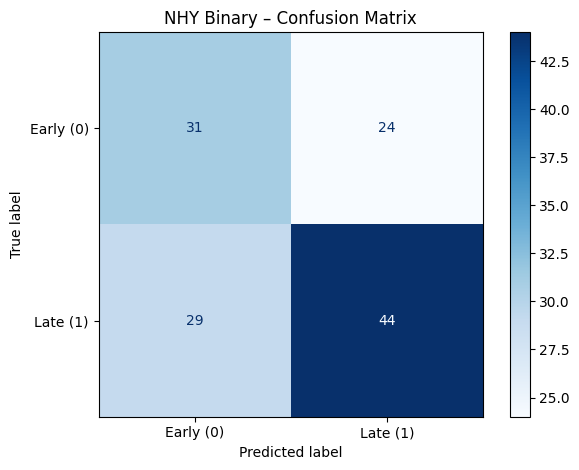

In [36]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluate
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Early (0)", "Late (1)"]))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Early (0)", "Late (1)"], cmap="Blues")
plt.title("NHY Binary – Confusion Matrix")
plt.tight_layout()
plt.show()